Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [42]:
## If you are using the data by mounting the google drive, use the following :
#from google.colab import drive
#drive.mount('/content/drive/')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166



This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(r"C:\Users\Admin\MyPractice\Deep_Learning\Melanoma_Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path(r"C:\Users\Admin\MyPractice\Deep_Learning\Melanoma_Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test")
print(data_dir_train.exists())


True


In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [49]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

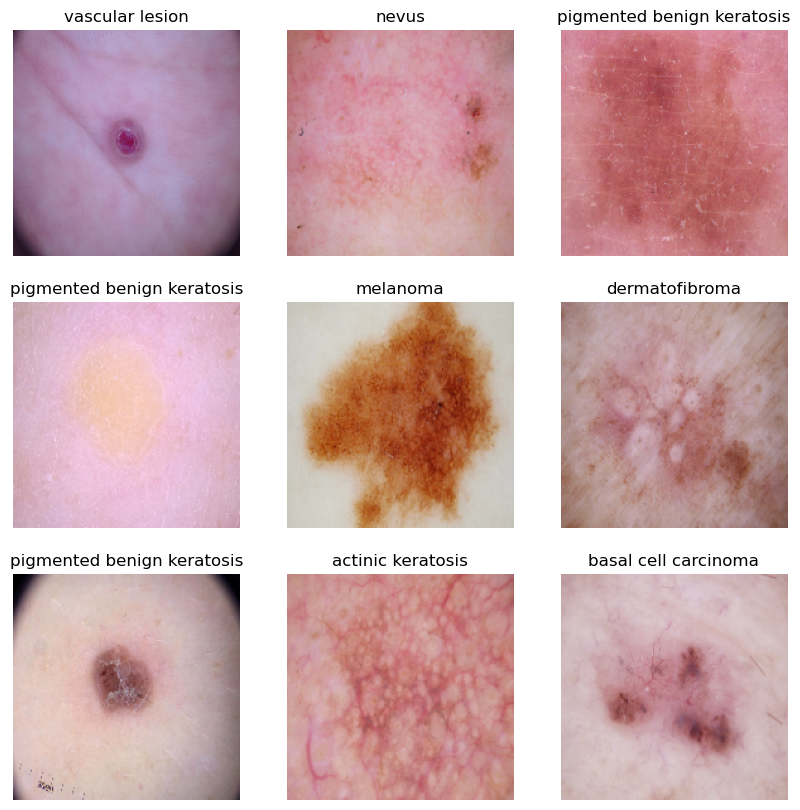

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [51]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [52]:
scaling = layers.Rescaling(1./255)
scaled_ds = train_ds.map(lambda x, y: (scaling(x), y))
image_batch, labels_batch = next(iter(scaled_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.06519608 0.9759806


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [53]:
### Todo, choose an appropirate optimiser and loss function
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
# View the summary of all layers
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [55]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 401ms/step - accuracy: 0.2015 - loss: 2.2685 - val_accuracy: 0.3221 - val_loss: 1.9559
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 328ms/step - accuracy: 0.3413 - loss: 1.8767 - val_accuracy: 0.4116 - val_loss: 1.6864
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 355ms/step - accuracy: 0.4342 - loss: 1.5878 - val_accuracy: 0.5034 - val_loss: 1.5404
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 406ms/step - accuracy: 0.5322 - loss: 1.3592 - val_accuracy: 0.5123 - val_loss: 1.5357
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 407ms/step - accuracy: 0.5374 - loss: 1.3188 - val_accuracy: 0.5347 - val_loss: 1.4026
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 392ms/step - accuracy: 0.5680 - loss: 1.2234 - val_accuracy: 0.5168 - val_loss: 1.4631
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 403ms/step - accuracy: 0.5890 - loss: 1.1473 - val_accuracy: 0.5391 - val_loss: 1.3604
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 401ms/step - accuracy: 0.6455 - loss: 1.0017 - val_accu

### Visualizing training results

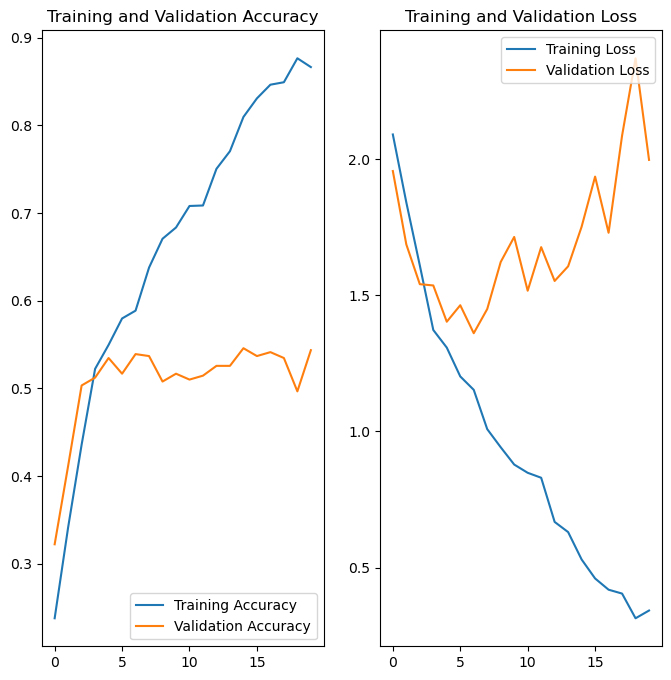

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

 ### Inferences
 - Training accuracy is 84%, validation accuracy is 54%
 - This model is clearly overfitting.
 - Validation loss keeps on increasing
 - Validation accuracy stops around 50%

### Further steps to improve the model
- to improve the model, augumentaion should be used
- Drop out will also help to control overfitting

In [57]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


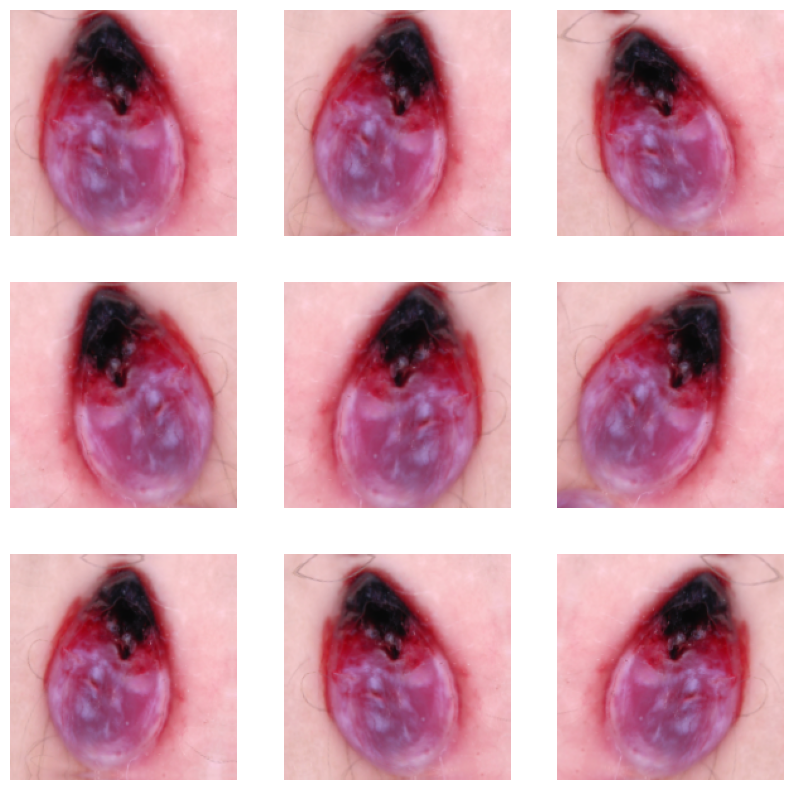

In [58]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_img = augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_img[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [59]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])



### Compiling the model

In [60]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [61]:
## Your code goes here, note: train your model for 20 epochs
epochs = 15
history = history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 468ms/step - accuracy: 0.1692 - loss: 2.3001 - val_accuracy: 0.1924 - val_loss: 2.0250
Epoch 2/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 406ms/step - accuracy: 0.2679 - loss: 1.9301 - val_accuracy: 0.3199 - val_loss: 1.8665
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 424ms/step - accuracy: 0.3240 - loss: 1.8053 - val_accuracy: 0.3244 - val_loss: 1.6927
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 435ms/step - accuracy: 0.4165 - loss: 1.6122 - val_accuracy: 0.4720 - val_loss: 1.4956
Epoch 5/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 420ms/step - accuracy: 0.4969 - loss: 1.4615 - val_accuracy: 0.4989 - val_loss: 1.5015
Epoch 6/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 448ms/step - accuracy: 0.4964 - loss: 1.4196 - val_accuracy: 0.4653 - val_loss: 1.4954
Epoch 7/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 426ms/step - accuracy: 0.5108 - loss: 1.3716 - val_accuracy: 0.4676 - val_loss: 1.4921
Epoch 8/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 410ms/step - accuracy: 0.5118 - loss: 1.3519 - val_accu

### Visualizing the results

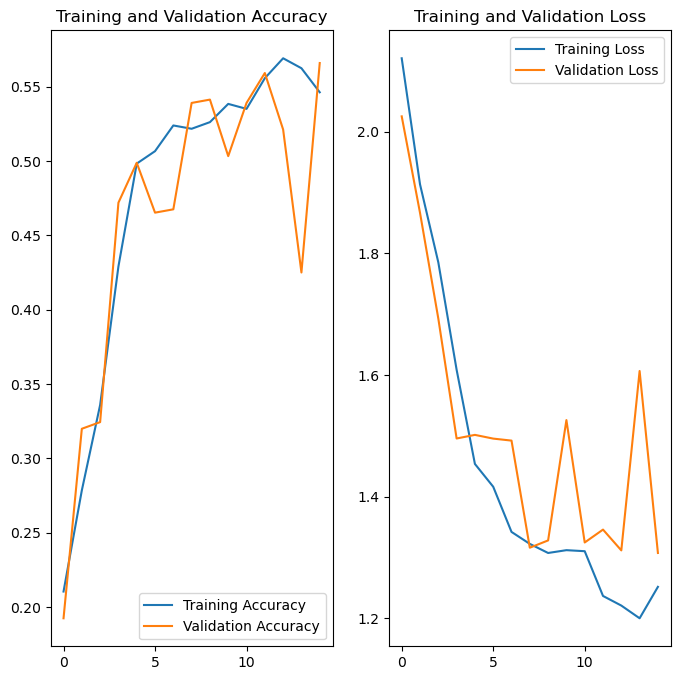

In [62]:
epochs=15
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Inferences
- The overfitting is controlled after using data auhgumentation and including dropout in the model
- However the accuracy i around 50%, which need to be further improved

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [12]:
from collections import Counter
def findImbalance(data_dir):
    class_directories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    class_counts = Counter()

    for class_dir in class_directories:
        class_images_dir = os.path.join(data_dir, class_dir)
        num_images = len([f for f in os.listdir(class_images_dir) if os.path.isfile(os.path.join(class_images_dir, f))])
        class_counts[class_dir] = num_images

    plt.figure(figsize=(8, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel("Class Label")
    plt.ylabel("Count")
    plt.title("Class Distribution")
    plt.xticks(rotation=90)  # Rotate class labels for better readability
    plt.show()


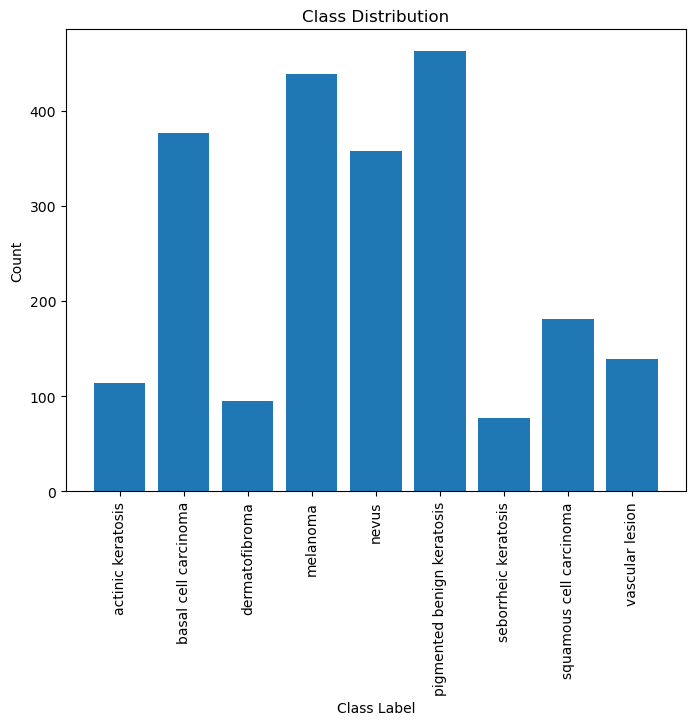

In [13]:
findImbalance(data_dir_train)

#### Inferences
- The data is clearly imbalanced across different classes
- "Pigmented benign keratosis" has the highest proportion of samples
- Seborrheic keratosis has the lowest number of samples
- Comparitively melanoma, nevus and basal cell carcinoma has higher number of samples than other classes


### Augumentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [84]:
path_to_training_dataset=("Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2762B226F10>: 100%|██████████| 500/500 [00:13<00:00, 37.60 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x27626D9DD10>: 100%|██████████| 500/500 [00:13<00:00, 36.30 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x27626CE69D0>: 100%|██████████| 500/500 [00:13<00:00, 37.48 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x27627D947D0>: 100%|██████████| 500/500 [00:52<00:00,  9.48 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x276268B81D0>: 100%|██████████| 500/500 [00:56<00:00,  8.91 Samples/s]                  


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x27626D59110>: 100%|██████████| 500/500 [00:14<00:00, 34.95 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x27626C281D0>: 100%|██████████| 500/500 [00:28<00:00, 17.69 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x27626695850>: 100%|██████████| 500/500 [00:13<00:00, 36.72 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2762B4532D0>: 100%|██████████| 500/500 [00:13<00:00, 36.94 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [85]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [89]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['C:\\Users\\Admin\\MyPractice\\Deep_Learning\\Melanoma_Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_46b50362-a5d0-408d-bd32-b91dd4af6f55.jpg',
 'C:\\Users\\Admin\\MyPractice\\Deep_Learning\\Melanoma_Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_59b1fdd7-d935-469f-88f4-64c6b867f8de.jpg',
 'C:\\Users\\Admin\\MyPractice\\Deep_Learning\\Melanoma_Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_c5c7734c-1053-4d24-afad-ddbba83f2e4b.jpg',
 'C:\\Users\\Admin\\MyPractice\\Deep_Learning\\Melanoma_Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_e3d14263-b32a-4e1f-85f7-e7dc885badd

In [91]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [93]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [98]:
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,C:\Users\Admin\MyPractice\Deep_Learning\Melano...,actinic keratosis
1,C:\Users\Admin\MyPractice\Deep_Learning\Melano...,actinic keratosis
2,C:\Users\Admin\MyPractice\Deep_Learning\Melano...,actinic keratosis
3,C:\Users\Admin\MyPractice\Deep_Learning\Melano...,actinic keratosis
4,C:\Users\Admin\MyPractice\Deep_Learning\Melano...,actinic keratosis
...,...,...
4495,C:\Users\Admin\MyPractice\Deep_Learning\Melano...,vascular lesion
4496,C:\Users\Admin\MyPractice\Deep_Learning\Melano...,vascular lesion
4497,C:\Users\Admin\MyPractice\Deep_Learning\Melano...,vascular lesion
4498,C:\Users\Admin\MyPractice\Deep_Learning\Melano...,vascular lesion


In [96]:
new_df['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [97]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [100]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [101]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [102]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [103]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### **Todo:**  Train your model

In [104]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 110s 615ms/step - accuracy: 0.2189 - loss: 2.0555 - val_accuracy: 0.4261 - val_loss: 1.4665
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 94s 548ms/step - accuracy: 0.4216 - loss: 1.5157 - val_accuracy: 0.4358 - val_loss: 1.4430
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 96s 557ms/step - accuracy: 0.4619 - loss: 1.4175 - val_accuracy: 0.4848 - val_loss: 1.3504
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 95s 553ms/step - accuracy: 0.4820 - loss: 1.3136 - val_accuracy: 0.5479 - val_loss: 1.2219
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 100s 584ms/step - accuracy: 0.5162 - loss: 1.2526 - val_accuracy: 0.5523 - val_loss: 1.2298
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 92s 537ms/step - accuracy: 0.5412 - loss: 1.1919 - val_accuracy: 0.5405 - val_loss: 1.2057
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 93s 542ms/step - accuracy: 0.5576 - loss: 1.1581 - val_accuracy: 0.5917 - val_loss: 1.0959
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 100s 583ms/step - accuracy: 0.5574 - loss

#### **Todo:**  Visualize the model results

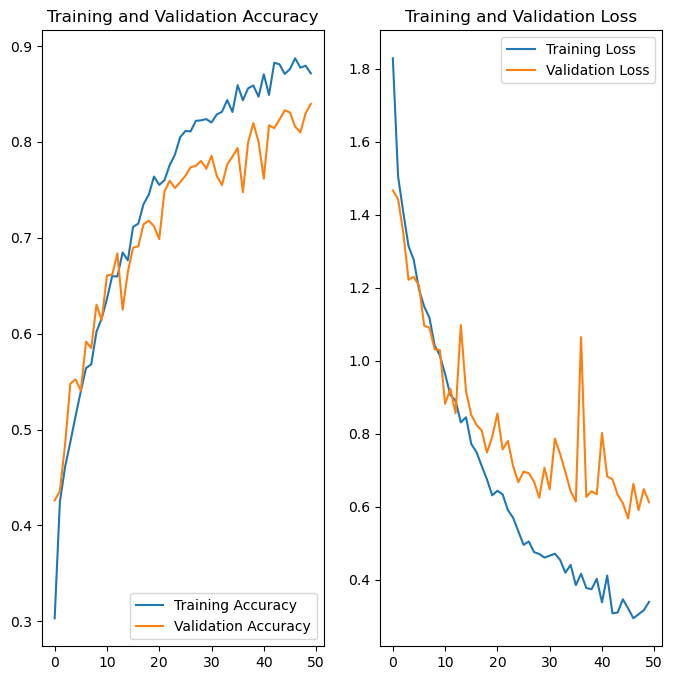

In [105]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### Overall Analysis
- The data is divided into training and validation set along with resizing the images
- The image went through scaling. As it is an RGB image,(image/255) approach is applied
- A model is built uing the rescaled images and basic layers. It had around 80% of training accuracy and 50% of validation acuuracy
- The model was clearly overfitting
- To control overfitting dropout technique was used along with data augumentation.
- The revised model gave around 50% training and validation accuracy
- On further analysis, heavy class imbalance was found. 'actinic keratosis','dermatofibroma', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion' classes had comparitively very less train data
- This issue was resolved by using Augumentor technique. 500 sample datas were added to all the classes to reduce imbalance
- In the final model rescaling, augumentation and dropout techniques were included
- The final model showed a drastic increase in training and validation accuracy more thatn 80%
- The dropout and augumentation techniques helped in controlling overfitting
- Augumentor is usd to neutralize class imbalance risk
- All these factors contributed to building a more accurate model